In [ ]:
!apt-get update && apt-get install -y poppler-utils

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,434 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu 

In [ ]:
!pip install pdf2image opencv-python pytesseract pillow numpy

In [ ]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint

# Setting required paths related to library functions
POPPLER_PATH = r"/usr/bin"
TESSERACT_ENGINE_PATH = '/usr/bin/tesseract'
pytesseract.pytesseract.tesseract_cmd = TESSERACT_ENGINE_PATH

In [ ]:
DOC_PATH = "/content/pre_1.pdf"

In [ ]:
# Converting pdf to images (function returns a PIL Image object)
pages = convert_from_path(DOC_PATH, poppler_path=POPPLER_PATH)
pages

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

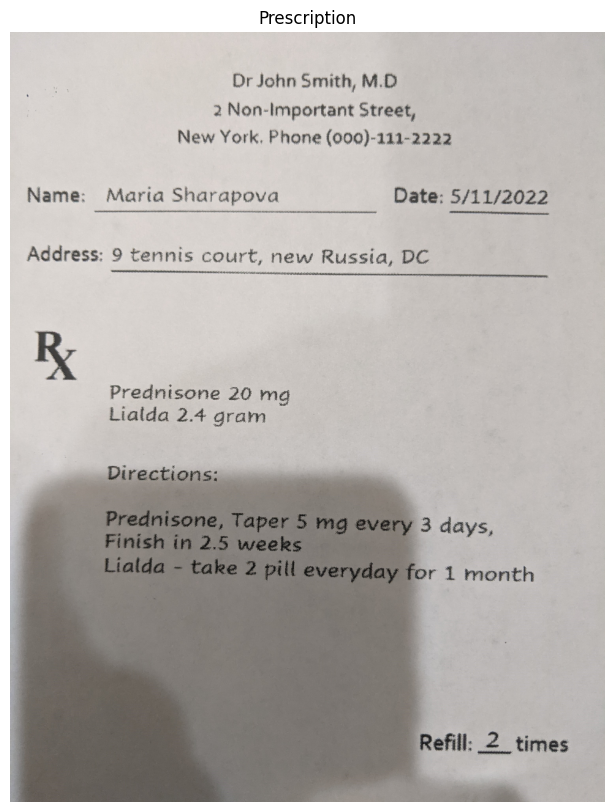

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(pages[0])
plt.axis(False)
plt.title('Prescription')
plt.show()

In [ ]:
# Extract text from image using pytesseract
text = pytesseract.image_to_string(pages[0], lang="eng")
print(text)

Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Maria Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

—moemennannennemneneunmnmnnnnie sisson aNd eennteinenarnrnen:

Prednisone 20 mg
Lialda 2.4 gram

 
 
   

3 days,

or 1 month



In [ ]:
# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        63, # block size (after trial and error)
        12  # constant (after trial and error)
    )
    return processed_image

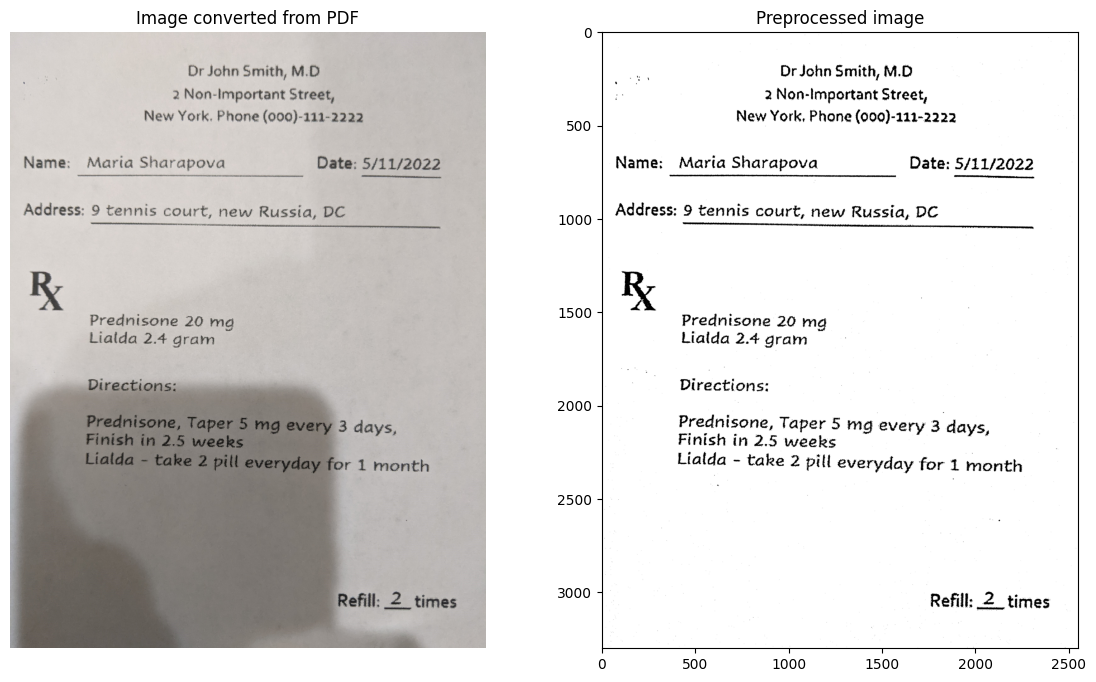

In [ ]:
# Applying preprocessing on image
img = preprocess_image(pages[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()

In [ ]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

Dr John Smith, M.D
2 Non-Important Street,
New York, Phone (000)-111-2222

Name: Marta Sharapova Date: 5/11/2022

Address: 9 tennis court, new Russia, DC

Prednisone 20 mg
Lialda 2.4 gram

Directions:

Prednisone, Taper 5 mg every 3 days,
Finish in 2.5 weeks -
Lialda - take 2 pill everyday for 1 month

Refill: _2_ times



In [ ]:
# A function to return useful information in JSON format
def parse(text: str) -> Dict:
    return{
        "patient_name": get_field("patient_name", text),
        "patient_address": get_field("patient_address", text),
        "medicines": get_field("medicines", text),
        "directions": get_field("directions", text),
        "refill": get_field("refill", text)
    }

# A function to find useful information from our text using Regular Expressions
def get_field(field_name: str, text: str) -> str:
    pattern_dict = {
        "patient_name": {"pattern": "Name:(.*)Date", "flags": 0},
        "patient_address": {"pattern": "Address:(.*)\n", "flags": 0},
        "medicines": {"pattern": "Address:[^\n]*(.*)Directions", "flags": re.DOTALL},
        "directions": {"pattern": "Directions:.(.*)Refill", "flags": re.DOTALL},
        "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},
    }

    pattern_object = pattern_dict.get(field_name)
    if pattern_object:
        matches = re.findall(pattern_object["pattern"], text, flags=pattern_object["flags"])
        if len(matches) > 0:
            return matches[0].strip()

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-391750326.py:18: SyntaxWarning: invalid escape sequence '\d'
  "refill": {"pattern": "Refill:.*(\d).*times", "flags": 0},


In [ ]:
print(parse(text_1))

{'patient_name': 'Marta Sharapova', 'patient_address': '9 tennis court, new Russia, DC', 'medicines': 'Prednisone 20 mg\nLialda 2.4 gram', 'directions': 'Prednisone, Taper 5 mg every 3 days,\nFinish in 2.5 weeks -\nLialda - take 2 pill everyday for 1 month', 'refill': '2'}


In [ ]:
# #Let's get useful fields from our different chunks
# text_list = [text_1, text_2]
# for i in range(len(text_list)):
#     print(f"Important fields from text {i+1}:\n")
#     print(parse(text_list[i]))
#     print("\n----------------------\n")